# Лабораторная работа № 3
### Минимальная оценка - 3 балла
### Максимальная оценка - 5 балла
Целью данной работы является изучение метода градиентного бустинга.
Для успешной сдачи лабораторной работы Вам необходимо предоставить заполненый исходный ноутбук.

In [1]:
import tqdm
import numpy as np
from scipy.special import expit as sigmoid
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
N = 10
V = (N % 2) + 1
print(f'Вариант {V}')

Вариант 1


## Задание 1 (3 балла)
Нужно реализовать класс для модели градиентного бустинга на деревьях и вспомогательные классы для функцию потерь BCE или MSE.

#### 1.1. Базовый класс Loss

Сначала напишем базовый класс `Loss`, от которого будем наследоваться при написании функций потерь.
Вычисление значения функции потерь будет производиться в методе `forward`, а градиента - в методе `backward`.

Метод `forward` должен получать на вход два вектора: вектор целевых переменных и вектор предсказаний модели.
Метод должен: 
* проверять, что длины векторов совпадают (с помощью `assert`)
* возвращать вектор той же длины, содержащий значения функции потерь для каждого из объектов

Метод `grad` должен делать то же самое, но возвращать значение градиента функции потерь.

In [3]:
class Loss(object):
    
    def __call__(self, y, p):
        """
        Call and use .forward()
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        
        return self.forward(y, p)
        
    def forward(self, y, p):
        """
        Calculate loss value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        
        raise NotImplementedError
        
    def grad(self, y, p):
        """
        Calculate grad value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like grad values
        """
        
        raise NotImplementedError

### Вариант 1
#### 1.2. Функция потерь для задачи регрессии (MSE)
Для задачи регрессии будем использовать `Mean Squared Error (MSE)`:

$$L = MSE(y,p) = \frac{1}{2n}(y - p) ^ 2$$

Ее градиент:
$$\frac{\partial L}{\partial p} = \frac{1}{n}(p - y)$$

В формулах выше `p` - предсказания модели.

In [4]:
class MSELoss(Loss):
    def forward(self, y, p):
        assert y.shape == p.shape
        return np.power(y - p, 2) / (2 * y.shape[0])
    
    def grad(self, y, p):
        assert y.shape == p.shape
        return (p - y) / y.shape[0]

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [5]:
mse_loss = MSELoss()

ys = np.array((10, 20, 30))
ps = np.array((5, 25, 30))

np.testing.assert_raises(AssertionError, mse_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, mse_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_almost_equal(mse_loss(ys, ps), np.asarray([4.16667, 4.1666, 0]), decimal=4)
np.testing.assert_almost_equal(mse_loss.grad(ys, ps), np.asarray([-1.66667, 1.66667, 0]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

### 2. Градиентный бустинг

#### 2.1. Класс GradentBoosting
После того, как были получены классы для функций потерь, можно приступать к реализации класса для градиентного бустинга `GradientBoosting`.
В качестве базовых моделей будем использовать деревья решений (`DecisionTreeRegressor` из `sklearn.tree`).
Итоговый вид композиции:
$$a(x) = \sum_{t=1}^{T}\eta * b_{t}(x)$$

Параметры класса (аргументы метода `__init__()`):
* `loss`: объект одного из двух классов, реализованных выше (`MSELoss` или `BCELoss`), будет определять поведение при вызове метода `predict()`.
* `n_estimators`: число деревьев `T` (итераций бустинга)
* `learning_rate`: темп обучения (коэффициент $\eta$)
* `max_depth`: максимальная глубина построенных деревьев (параметр `DecisionTreeRegressor`)
* `max_features`: число признаков для поиска наилучшего разбиения в узле (параметр `DecisionTreeRegressor`)

В методе `__init__()` создаются списки для хранения отдельных деревьев (`self.estimators`) и значений функции потерь на каждом шаге (`self.loss_values`).
Также имеется дополнительное поле `self.loss_values_evalset`, в котором можно хранить значения функции потерь на отложенной (`evalset`) выборке по итерациям.

Метод `fit(X, y, X_eval=None, y_eval=None)` должен:
* Инициализировать "нулевое приближение" средним значением целевой переменной, считать значение потерь при нем
* Итерируясь по числу деревьев:
  * Вычислять **антиградиент** функции потерь построенной композиции по каждому объекту (остатки), создавать новое дерево, обучать его на полученных остатках и добавлять в список деревьев.
  * Вычислять новое значение предсказания композиции для обучающей выборки (добавлением ответов нового дерева с весом $\eta$)
  * Считать новое значение функции потерь (суммарно по всем объектам) и добавлять в список
* В случае, если методу передаются также `X_eval` и `y_eval`, нужно вычислять значение функции потерь на этом множестве на каждой итерации.
  
Метод `predict(X)` должен:
* Для каждого объекта из `X` делать предсказание с помощью всех деревьев композиции  (**не забывайте про "нулевое приближение"**) и суммировать их
* Если решается задача классификации, применять сигмоиду на полученных ответах

In [6]:
class GradientBoosting(BaseEstimator):
    
    class _MeanEstimator(BaseEstimator):
        def __init__(self, *args, **kwargs):
            self.mean = None

        def fit(self, X, y, *args, **kwargs):
            self.mean = np.mean(y)

        def predict(self, X, *args, **kwargs):
            return np.full((X.shape[0],), self.mean)
        
    
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features=1.0,
                 random_state=2):
        
        self.loss = loss
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        
        self.max_depth = max_depth
        self.max_features = max_features
        
        self.estimators = []
        self.loss_values = []
        
        self.random_state = random_state
        
        #
        # Это списки хуков и контекст для них
        #
        
        self._initial_hooks = []
        self._indices_hooks = []
        self._estimator_hooks = []
        
        self.context = {}
    
    
    def fit(self, X, y, X_val=None, y_val=None):

        @GradientBoosting.hook
        def initial_hook(context, initial, X_val, y_val):
            context['y_pred_val'] = initial.predict(X_val)
            context['loss_values_val'].append(np.sum(self.loss(y_val, context['y_pred_val'])))
                
        @GradientBoosting.hook
        def estimator_hook(context, estimator, X_val, y_val):
            context['y_pred_val'] += self.learning_rate * estimator.predict(X_val)
            context['loss_values_val'].append(np.sum(self.loss(y_val, context['y_pred_val'])))
        
        if X_val is not None and y_val is not None:
            self.context['loss_values_val'] = []
            
            self.register_initial_hook(initial_hook)
            self.register_estimator_hook(estimator_hook)
            
        self._fit(X, y, X_val=X_val, y_val=y_val)
    
    
    def predict(self, X):
        return sum(self.learning_rate * e.predict(X) 
                   for e in self.estimators)
    
    
    def register_initial_hook(self, hook):
        self._initial_hooks.append(hook)
        
        
    def register_indices_hook(self, hook):
        self._indices_hooks.append(hook)
        

    def register_estimator_hook(self, hook):
        self._estimator_hooks.append(hook)
                
            
    def hook(f):
        import inspect
        f_args = inspect.getfullargspec(f).args
        
        def wrapper(**kwargs):
            #
            # Передам только те аргументы, которые понимаются хуком
            #
            
            suitable_kwargs = {k: v for k, v in kwargs.items() if k in f_args}
            return f(**suitable_kwargs)
        
        return wrapper
        
    
    def _run_initial_hooks(self, **kwargs):
        for h in self._initial_hooks:
            h(context=self.context, **kwargs)
            
            
    def _run_indices_hooks(self, size, **kwargs):
        indices = list(range(size))
        
        for h in self._indices_hooks:
            indices = h(context=self.context, indices=indices, size=size, **kwargs)
            
        return indices
            
            
    def _run_estimator_hooks(self, **kwargs):
        #
        # Тут вот как получается: если возвращается что-то в качестве результата,
        # то я это что-то учту для ранней остановки
        # Хук должен вернуть False, если надо остановиться
        #
        
        return all([r for h in self._estimator_hooks 
                    if (r := h(context=self.context, **kwargs)) is not None])
    
    
    def _fit(self, X, y, **kwargs):
        #
        # Начальное приближение -- просто среднее по y
        #
        
        initial = GradientBoosting._MeanEstimator()
        initial.fit(X, y)
        
        y_pred = initial.predict(X)
        
        self.estimators.append(initial)
        self.loss_values.append(np.sum(self.loss(y, y_pred)))
        
        #
        # Теперь запускаю хуки, если есть
        #
        
        self._run_initial_hooks(initial=initial, y_pred=y_pred, **kwargs)
        
        #
        # А теперь сами деревца
        #
        
        for i in tqdm.trange(1, self.n_estimators):
            #
            # Считаю остатки от предыдущих моделей как антиградиент лосса
            # После этого обучаю деревце получать эти остатки на трейне,
            # потом прибавив их к суммарному предсказанию
            #

            estimator = DecisionTreeRegressor(max_depth=self.max_depth, 
                                              max_features=self.max_features, 
                                              random_state=self.random_state)

            indices = self._run_indices_hooks(size=X.shape[0], **kwargs)
            
            residuals = -self.loss.grad(y, y_pred)
            estimator.fit(X[indices], residuals[indices])

            y_pred += self.learning_rate * estimator.predict(X)

            self.estimators.append(estimator)
            self.loss_values.append(np.sum(self.loss(y, y_pred)))
            
            #
            # И снова запуск хуков
            #
            
            if False == self._run_estimator_hooks(estimator=estimator, y_pred=y_pred, iteration=i, **kwargs):
                break

#### 2.2. Тестирование класса GradientBoosting

##### 2.2.1. Интерфейс
*Код в ячейках ниже должен выполняться без ошибок.*

In [7]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 3956.70it/s]


In [8]:
assert len(gb_test.estimators) == gb_test.n_estimators
assert gb_test.predict(X_test).shape == y_test.shape

Сгенерируем случайную выборку и убедимся, что функция потерь уменьшается при увеличении итераций.

*Код в ячейках ниже должен выполняться без ошибок.*

### Вариант 1
##### 2.2.2. Регрессия

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 5218.17it/s]


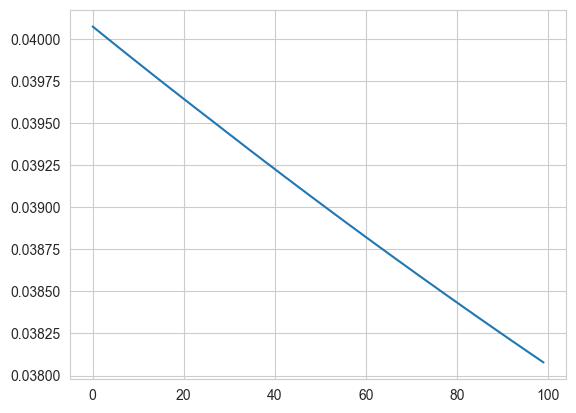

In [9]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

### 3. Использование класса GradientBoosting

Проверим, как работает наш бустинг на двух задачах - регрессии и классификации на 2 класса.
Для этого будем использовать игрушечные выборки, полученные с помощью `sklearn.datasets.make_regression` и `sklearn.datasets.make_classificaiton`.

In [10]:
from sklearn.metrics import accuracy_score, mean_squared_error

### Вариант 1
#### Задача регрессии

In [11]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [12]:
gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X, y, X_val=X_val, y_val=y_val)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 3850.84it/s]


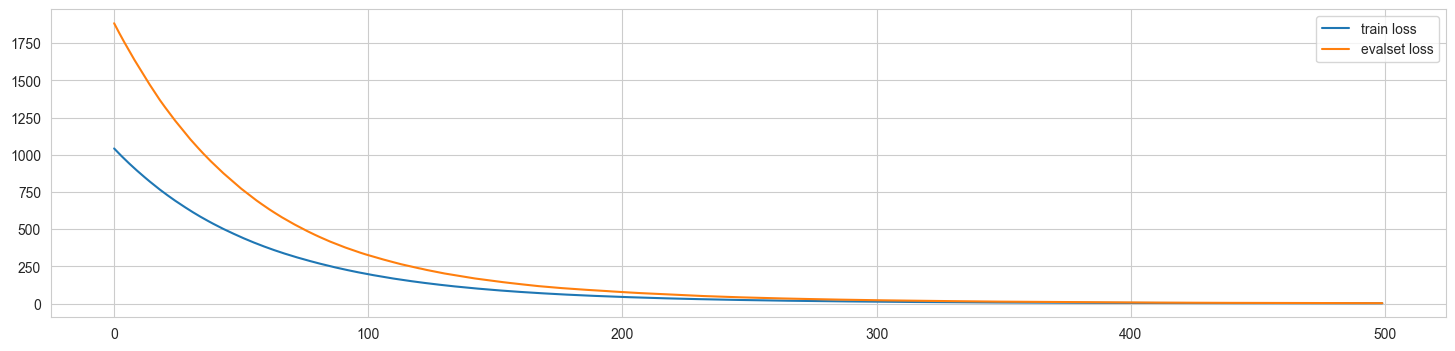

In [13]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.loss_values, label='train loss')
plt.plot(gb_regressor.context['loss_values_val'], label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "среднее по датасету" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций они должны отличаться как минимум в 100 раз.

*Код в ячейках ниже должен выполняться без ошибок.*

In [14]:
# Train
y_mean = np.mean(y_train) * np.ones_like(y_train)
mse_baseline = mean_squared_error(y_train, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_train)
mse_boosting = mean_squared_error(y_train, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 1648.606
MSE для предсказаний бустинга: 2.823


In [15]:
# Val
y_mean = np.mean(y_val) * np.ones_like(y_val)
mse_baseline = mean_squared_error(y_val, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_val)
mse_boosting = mean_squared_error(y_val, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 3531.394
MSE для предсказаний бустинга: 4.759


## Задание 2 (2 балла)
- Реализация ранней остановки обучения
- Реализация вычисления дополнительной метрики качества на каждой итерации
- Реализация бэггинга при обучении отдельных деревьев

Для того, чтобы дополнительные баллы были засчитаны, необходимо реализовать функционал и продемонстрировать результат в ячейке внизу.

In [16]:
def r_squared(y, p):
    return 1 - sum(np.power(y - p, 2)) / sum(np.power(y - np.mean(y), 2))

In [17]:
class GradientBoostingEx(GradientBoosting):
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features=1.0,
                 random_state=2):
        
        super(GradientBoostingEx, self).__init__(loss=loss, 
                                                 n_estimators=n_estimators, 
                                                 learning_rate=learning_rate, 
                                                 max_depth=max_depth, 
                                                 max_features=max_features, 
                                                 random_state=random_state)
    
    
    def fit(self, X, y, 
            X_val=None, 
            y_val=None, 
            metric=None,
            bagging_size=None,
            early_stop_threshold=None):
        
        #
        # В сущности история то та же самая, что и раньше, просто хуки другие навешу
        #
        
        @GradientBoosting.hook
        def initial_metric_hook(context, y_pred, metric):
            context['metric_values'].append(metric(y, y_pred))
        
        @GradientBoosting.hook
        def initial_validation_hook(context, initial, X_val, y_val):
            context['y_pred_val'] = initial.predict(X_val)
            context['loss_values_val'].append(np.sum(self.loss(y_val, context['y_pred_val'])))
            
        @GradientBoosting.hook
        def initial_validation_metric_hook(context, y_val, metric):
            context['metric_values_val'].append(metric(y_val, context['y_pred_val']))
        
        @GradientBoosting.hook
        def estimator_metric_hook(context, y_pred):
            context['metric_values'].append(metric(y, y_pred))
            
        @GradientBoosting.hook
        def estimator_validation_hook(context, estimator, X_val, y_val):
            context['y_pred_val'] += self.learning_rate * estimator.predict(X_val)
            context['loss_values_val'].append(np.sum(self.loss(y_val, context['y_pred_val'])))
            
        @GradientBoosting.hook
        def estimator_validation_metric_hook(context, y_val, metric):
            context['metric_values_val'].append(metric(y_val, context['y_pred_val']))
        
        @GradientBoosting.hook
        def estimator_early_stopping_hook(context, iteration, early_stop_threshold):
            if iteration <= 2:
                return True
                
            difference = abs(context['loss_values_val'][-1] - context['loss_values_val'][-2]) \
                if needs_validation \
                else abs(self.loss_values[-1] - self.loss_values[-2])

            return difference >= early_stop_threshold
        
        @GradientBoosting.hook
        def indices_bagging_hook(size, bagging_size):
            return np.random.randint(size, size=int(bagging_size * size))
        
        needs_metric = metric is not None
        needs_validation = X_val is not None and y_val is not None
        needs_early_stopping = early_stop_threshold is not None
        needs_bagging = bagging_size is not None
        
        if needs_metric:
            self.context['metric_values'] = []
            
            self.register_initial_hook(initial_metric_hook)
            self.register_estimator_hook(estimator_metric_hook)
            
        if needs_validation:
            self.context['loss_values_val'] = []
            
            self.register_initial_hook(initial_validation_hook)
            self.register_estimator_hook(estimator_validation_hook)
        
        if needs_metric and needs_validation:
            self.context['metric_values_val'] = []
            
            self.register_initial_hook(initial_validation_metric_hook)
            self.register_estimator_hook(estimator_validation_metric_hook)
            
        if needs_early_stopping:
            self.register_estimator_hook(estimator_early_stopping_hook)
            
        if needs_bagging:
            self.register_indices_hook(indices_bagging_hook)
        
        self._fit(X, y, X_val=X_val, 
            y_val=y_val, 
            metric=metric,
            bagging_size=bagging_size,
            early_stop_threshold=early_stop_threshold)

In [18]:
gb_regressor = GradientBoostingEx(loss=MSELoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X, y, X_val=X_val, y_val=y_val,
    early_stop_threshold=0.1,
    metric=r_squared,
    bagging_size=0.5)

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 352/499 [00:00<00:00, 3724.27it/s]


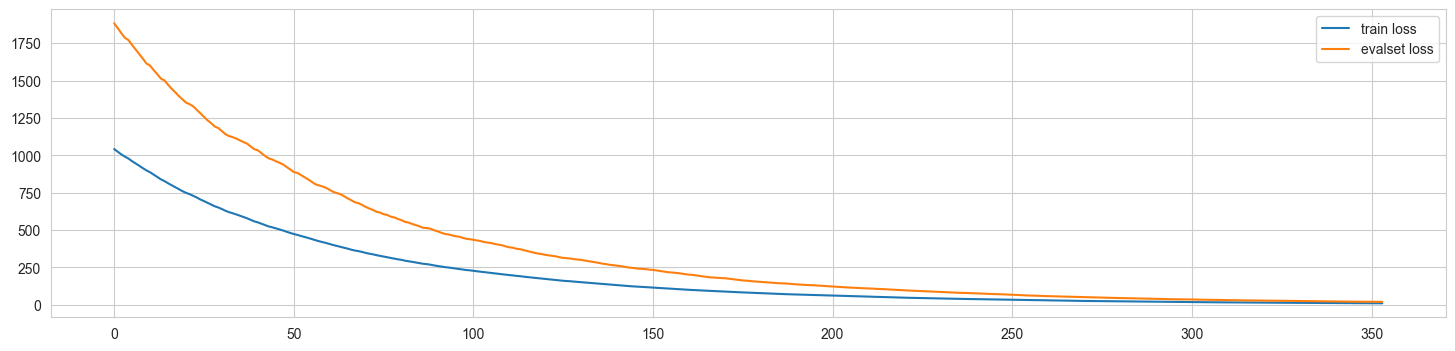

In [19]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.loss_values, label='train loss')
plt.plot(gb_regressor.context['loss_values_val'], label='evalset loss')
plt.legend()
plt.show()

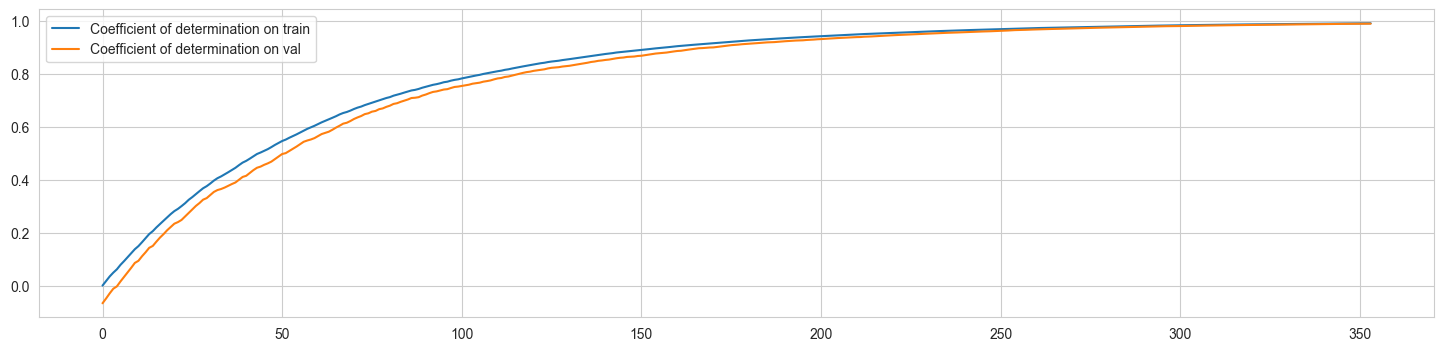

In [20]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.context['metric_values'], label='Coefficient of determination on train')
plt.plot(gb_regressor.context['metric_values_val'], label='Coefficient of determination on val')
plt.legend()
plt.show()